# TEMPE CRIME ANALYSIS

### Introduction

The city of Tempe and Arizona State University have released a historical dataset listing crimes committed over the last couple of years. The datasets includes case numbers, incident types, date and times of crime, and location data including latitude and longitude coordinates.

This notebook aims to explore and visualize some of this data. To begin, create an anconda environment based off enivroment.yml with this command:

conda env create -f environment.yml -n crime-analysis

Next, run the bash script download_data to download the data and import it into a Postgres database with this command:

./download_data

We'll start by importing necessary packages and getting the project file path.

numbersTaken as a whole, the detailed trip-level data is more than just a vast list of taxi pickup and drop off coordinates: it’s a story of New York. How bad is the rush hour traffic from Midtown to JFK? Where does the Bridge and Tunnel crowd hang out on Saturday nights? What time do investment bankers get to work? How has Uber changed the landscape for taxis? And could Bruce Willis and Samuel L. Jackson have made it from 72nd and Broadway to Wall Street in less than 30 minutes? The dataset addresses all of these questions and many more.

In [1]:
# Loads watermark extension and prints details about current platform
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas,psycopg2
 
# import packages
%matplotlib inline
%load_ext dotenv
# Use find_dotenv to locate the file
%dotenv

import pandas as pd
import pandas.io.sql as psql
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import psycopg2

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
print(PROJ_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))

Mon Nov 19 2018 

CPython 3.7.0
IPython 7.1.1

numpy 1.15.4
scipy 1.1.0
sklearn 0.20.0
pandas 0.23.4
psycopg2 2.7.5 (dt dec pq3 ext lo64)

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
/Users/sebp/LocalDocuments2/Data Science/Personal/tempe_crime_analysis


### 0.0 Import and Preview the Available Data

The bash script from earlier downloaded the data and imported it into a Postgres database. Now it's time to import the data into a pandas dataframe in this notebook.

In [2]:
connection = psycopg2.connect(user = os.getenv("DB_USER"),
                                  password = os.getenv("DB_PASSWORD"),
                                  host = os.getenv("DB_HOST"),
                                  port = os.getenv("DB_PORT"),
                                  database = os.getenv("DB_NAME"))
cur = connection.cursor()

tempe_crime_df = psql.read_sql("Select * from tempe_pd_offenses", connection)
asu_crime_df = psql.read_sql("Select * from asu_pd_offenses", connection)

Let's take a peak inside to see what our data looks like.

The city of Tempe dataset looks like this:

In [3]:
tempe_crime_df.head()

,id,latitude,longitude,incident_datetime,incident_address,disclaimer,place_name,offense,location_type
0,2001,33.4029,-111.965,2016-08-16T08:00:00.000Z,1XXX W FOUNTAINHEAD PKWY,Point has not been altered,WESTERN INTERNATIONAL UNIVERSITY,FRAUD,Commercial/Office Building ...
1,2002,33.3346,-111.946,2016-09-01T07:53:00.000Z,KYRENE RD / W WARNER RD,Point has not been altered,None,ACCIDENT-NO INJURY,Highway/Road/Alley/Sidewalk ...
2,2003,33.3783,-111.929,2016-09-03T23:53:00.000Z,RURAL RD / E BASELINE RD,Point has not been altered,None,ACCIDENT-INJURY,Highway/Road/Alley/Sidewalk ...
3,2004,33.3783,-111.930,2016-09-05T12:12:00.000Z,7XX E BASELINE RD,Point has not been altered,LOWE'S,SHOPLIFTING,Department/Discount Store ...
4,2005,33.3869,-111.939,2016-09-05T13:02:00.000Z,4XXX S MILL AVE,Point has not been altered,DAVENPORT APARTMENTS,CRIMINAL DAMAGE,Residence/Home ...


The ASU dataset looks like this:

In [4]:
asu_crime_df.head()

,id,case_number,incident_datetime,latitude,longitude,incident_address,city,offense,offense_type
0,18440147,2009-00011506,07/08/2009 12:00:00 AM,0.0000,0.000,None,Tempe,Time: 03:54:4<br>Criminal Damage,Other
1,826958308,2017-00089659,11/12/2017 12:00:00 AM,33.4220,-111.923,UNIVERSITY DR & AMP,TEMPE,Time: 00:06:4<br>Driving Under the Influence/Al,Quality of Life
2,826958309,2017-00090666,11/15/2017 12:00:00 AM,33.4534,-111.937,100 Block TAYLOR ST,TEMPE,Time: 09:49:5<br>Larceny Theft,Theft
3,826958310,2017-00090717,11/15/2017 12:00:00 AM,33.4535,-111.937,100 Block TAYLOR ST,TEMPE,Time: 13:03:0<br>Larceny Theft,Theft
4,826958311,2017-00090756,11/15/2017 12:00:00 AM,33.4548,-112.080,500 Block FILLMORE ST,PHOENIX,Time: 15:33:0<br>Traffic-Criminal,Traffic


# 1- Crime Data Exploration

### 1.0 Data Clean Up

Let's figure what we need to do to cleanup the data before doing anything with it.

We'll  find the data ranges of both data sets, and figure out how complete the dataset is.

While we're at it, we'll also convert the date columns to datetimes types.

In [5]:
print (len(tempe_crime_df) , 'tempe crime records.')
print (len(asu_crime_df) , 'asu crime records.')

tempe_crime_df['incident_datetime'] =  pd.to_datetime(tempe_crime_df['incident_datetime'])

print ('The oldest Tempe dataset crime is', tempe_crime_df.incident_datetime.min())
print ('The newest Tempe dataset crime is', tempe_crime_df.incident_datetime.max())
print ('Tempe dataset consistancy')
print (tempe_crime_df.count())

print ('\n')
asu_crime_df['incident_datetime'] =  pd.to_datetime(asu_crime_df['incident_datetime'])

print ('The oldest ASU dataset crime is', asu_crime_df.incident_datetime.min())
print ('The newest SU dataset crime is', asu_crime_df.incident_datetime.max())
print ('ASU dataset consistancy')
print (asu_crime_df.count())

165933 tempe crime records.
15153 asu crime records.
The oldest Tempe dataset crime is 1900-06-10 19:00:00
The newest Tempe dataset crime is 2018-11-11 10:43:00
Tempe dataset consistancy
id                   165933
latitude             165932
longitude            165932
incident_datetime    165374
incident_address     165933
disclaimer           165933
place_name            63656
offense              165280
location_type        165280
dtype: int64


The oldest ASU dataset crime is 1951-03-01 00:00:00
The newest SU dataset crime is 2018-02-09 00:00:00
ASU dataset consistancy
id                   15153
case_number          15153
incident_datetime    15153
latitude             15153
longitude            15153
incident_address     15140
city                 15153
offense              15153
offense_type         15153
dtype: int64


### 1.1 - Drop Missing Values

The ASU dataset seems fairly consistent, but the Tempe dataset is a little more sporadic.

Most columns in the Tempe dataset have similar numbers of values besides `place_name`, which is not present for most of the rows, likely because many crimes occur on streets or places with no name.

For our analysis, it will be best to have the exact same number of values for each field. We'll go ahead now and make sure that every single cell in the `place_name` column has a value, and then drop all missing rows.

In [6]:
# Fill missing search type values with placeholder
tempe_crime_df['place_name'].fillna('N/A', inplace=True)

# Drop rows with missing values
tempe_crime_df.dropna(inplace=True)

print('When we count the values again, we\'ll see that each column has the exact same number of entries.')
tempe_crime_df.count()

When we count the values again, we'll see that each column has the exact same number of entries.


id                   165279
latitude             165279
longitude            165279
incident_datetime    165279
incident_address     165279
disclaimer           165279
place_name           165279
offense              165279
location_type        165279
dtype: int64

We'll make sure the asu dataset also has the same number of values for each field.

In [7]:
# Drop rows with missing values
asu_crime_df.dropna(inplace=True)

print('When we count the values again, we\'ll see that each column has the exact same number of entries.')
asu_crime_df.count()

When we count the values again, we'll see that each column has the exact same number of entries.


id                   15140
case_number          15140
incident_datetime    15140
latitude             15140
longitude            15140
incident_address     15140
city                 15140
offense              15140
offense_type         15140
dtype: int64

### 1.2 - Remove Years Without Enough Data

As we saw earlier, this dataset streches quite a wide range of dates. It's very unlikely however that all the data is correct - the odds of one off records from over 100 years ago being correct is low.

Let's first visualize the amount of data per year to see what we're working with. We'll start by adding another column to our dataframes with just the year of the crime.

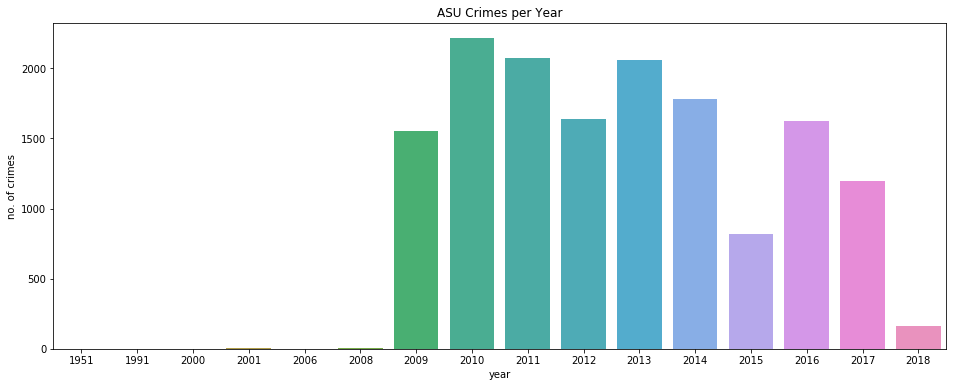

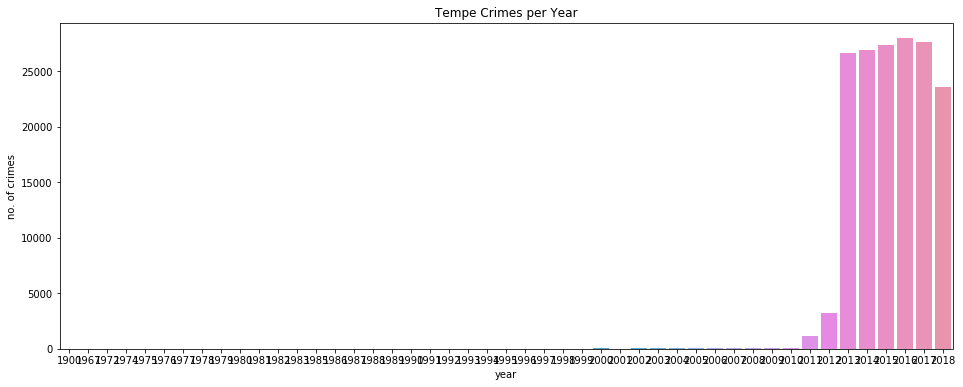

In [8]:
# asu_year_df = asu_crime_df[['incident_datetime']].copy()
asu_crime_df['year'] = asu_crime_df['incident_datetime'].map(lambda x: x.year)
tempe_crime_df['year'] = tempe_crime_df['incident_datetime'].map(lambda x: x.year)

# fig = plt.gcf()
# fig.set_size_inches( 16, 10)

plt.figure(figsize=(16, 6))
sns.countplot(x='year', data=asu_crime_df)
plt.ylabel('no. of crimes')
plt.title('ASU Crimes per Year')
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(x='year', data=tempe_crime_df)
plt.ylabel('no. of crimes')
plt.title('Tempe Crimes per Year')
plt.show()

The asu dataset seems to in 2009. Previous data is probably incorrectly labeled.

The Tempe dataset also is pretty sparse until 2011. For now, lets remove all data before 2009 in both datasets.

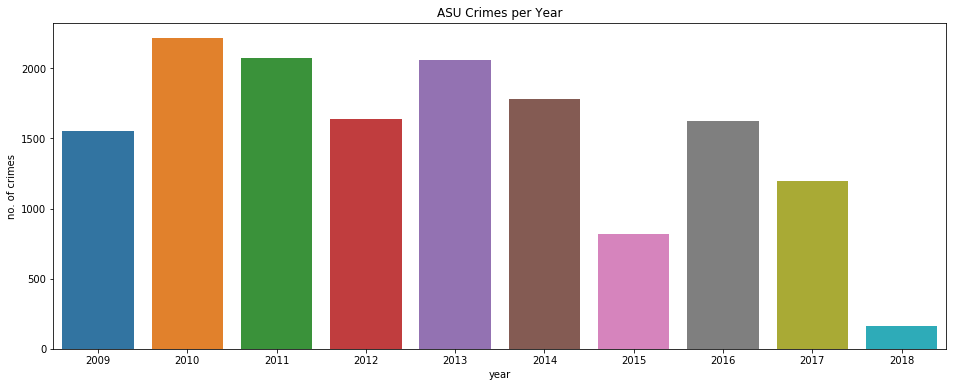

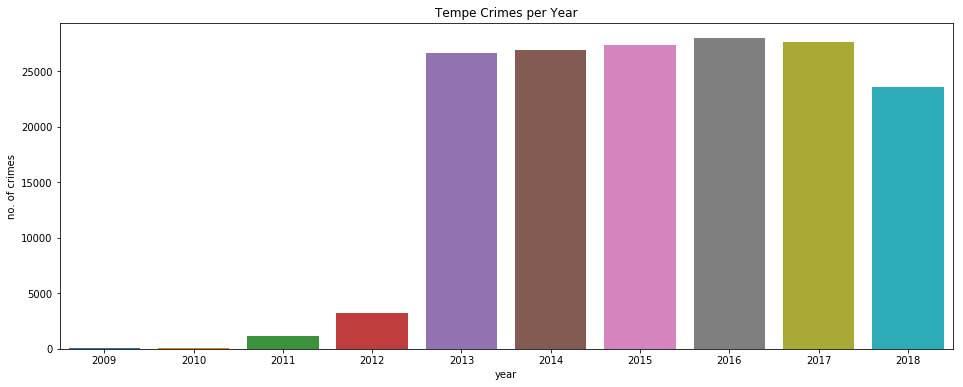

In [9]:
asu_crime_df = asu_crime_df[asu_crime_df.year >= 2009]
tempe_crime_df = tempe_crime_df[tempe_crime_df.year >= 2009]

plt.figure(figsize=(16, 6))
sns.countplot(x='year', data=asu_crime_df)
plt.ylabel('no. of crimes')
plt.title('ASU Crimes per Year')
plt.show()




plt.figure(figsize=(16, 6))
sns.countplot(x='year', data=tempe_crime_df)
plt.ylabel('no. of crimes')
plt.title('Tempe Crimes per Year')
plt.show()

### 1.3 - Remove HTML from data

The `offense` column in the ASU dataset contains html `<br>` along with duplicated time stamps before the html tag. Let's make our data cleaner and remove the html tags.

We'll use a lambda function to remove the html from every row in the `offense` column.

In [10]:
asu_crime_df.offense = asu_crime_df.offense.apply(lambda x: x.split("<br>",1)[1])

asu_crime_df.head()

,id,case_number,incident_datetime,latitude,longitude,incident_address,city,offense,offense_type,year
1,826958308,2017-00089659,2017-11-12,33.4220,-111.923,UNIVERSITY DR & AMP,TEMPE,Driving Under the Influence/Al,Quality of Life,2017
2,826958309,2017-00090666,2017-11-15,33.4534,-111.937,100 Block TAYLOR ST,TEMPE,Larceny Theft,Theft,2017
3,826958310,2017-00090717,2017-11-15,33.4535,-111.937,100 Block TAYLOR ST,TEMPE,Larceny Theft,Theft,2017
4,826958311,2017-00090756,2017-11-15,33.4548,-112.080,500 Block FILLMORE ST,PHOENIX,Traffic-Criminal,Traffic,2017
5,827155011,2017-00090703,2017-11-15,33.4183,-111.933,400 Block ORANGE ST,TEMPE,Larceny Theft,Theft,2017


### 1.4 - Crimes By Offense

Let's get a list of all offenses in the data set, along with how many offenses happened in each.

In [11]:
print ("ASU Offenses")
print (asu_crime_df['offense'].value_counts())

print ("\n\nTempe Offenses")
print(tempe_crime_df['offense'].value_counts())

ASU Offenses
Larceny Theft                      5787
Alcohol/Title 4 Violation          1822
Drug/Narcotic Violations           1427
Criminal Damage                    1175
Traffic-Criminal                   1085
Driving Under the Influence/Al      516
Trespass/Loitering                  453
Traffic-Civil                       411
Property-Found, Lost, Impound"      400
Accident/Non-Injury                 304
Assault, Misd or Other"             238
Warrant Arrest                      207
Disorderly Conduct                  122
Forgery/Fraud                       114
Suspicious Person/Activity          107
Property-Found, Lost, Impound       102
Assault, Misd or Other               85
Accident/Injuries                    84
Burglary/Vehicle                     76
Assault, Aggravated"                 72
Harassment/Stalking                  62
Threatening                          56
Burglary/Structure                   51
Impound for destruction              40
Robbery                    

It seems like ASU Campus Police tends to spend a large chunk of their time dealing with theft, followed by alcohol and drug violations. Tempe PD on the other hand deals more with accident and assaults, then theft. This makes sense when you consider that ASU PD spends most of their time dealing with dorm residents, where alcohol and drugs are banned. Tempe PD on the other hand has a greater jurisdiction and deals with more issues.

### 1.5 - ASU vs Tempe Crime Map Visualization

It's hard to grasp exactly where the jurisdiction of one police department ends and the next one begins. Let's plot out where each department responds on a map.

We'll plot out only crimes from 2017. We'll also randomly drop rows from the Tempe dataset for 2 reasons:

 - There's about 10 times more Tempe records, and we just care to see a rough approximation of where crime occurs
 - I'm using google maps to visualize the data, and there's a limit to how many free api calls you get
 
 - Note that a screenshot is rendered instead. To get an interactive map, uncomment the code below

In [21]:
print ("Creating 2017 Datasets...")

import gmaps
gmaps.configure(api_key=os.getenv("G_MAPS_API_KEY")) # Your Google API key

# df = gmaps.datasets.load_dataset_as_df('starbucks_kfc_uk')

# starbucks_df = asu_crime_df[asu_crime_df['chain_name'] == 'starbucks']
asu_crime_2017_df = asu_crime_df[asu_crime_df.year == 2017]


remove_n = 25000
tempe_crime_2017_df = tempe_crime_df[tempe_crime_df.year == 2017]
drop_indices = np.random.choice(tempe_crime_2017_df.index, remove_n, replace=False)
tempe_crime_2017_df = tempe_crime_2017_df.drop(drop_indices)


# NOTE: The code below tenders a comparison map of where asu and tempe pd respond. To save resources,
#       the code has been commented out, and a screenshot of the map included below. Uncomment the code
#       to create a new interactive map instead

# asu_crime_coordinates_df = asu_crime_2017_df[['latitude', 'longitude']]
# tempe_crime_coordinates_df = tempe_crime_2017_df[['latitude', 'longitude']]

# asu_layer = gmaps.symbol_layer(
#     asu_crime_coordinates_df, fill_color="green", stroke_color="green", scale=2
# )

# tempe_layer = gmaps.symbol_layer(
#     tempe_crime_coordinates_df, fill_color="red", stroke_color="red", scale=2
# )

# fig = gmaps.figure()
# fig.add_layer(asu_layer)
# fig.add_layer(tempe_layer)
# fig

Creating 2017 Datasets...


![comparison-map](../img/comparison.png)

ASU PD is primarily focused on patroling around campus, but they do occasionally respond to calls in the greater Tempe area. Interestingly enough, ASU responds to calls as far as Ahwatukee.

### 1.6 - ASU Crime Heatmap Visualization

Although they respond to off campus calls, ASU PD primarily patrols ASU's Tempe, Downtown, and West campus's. Let's find out where the most crime occurs on campus with a heatmap.

We'll reuse the 2017 data from the previous visualization.

Keep in mind a screenshot will be rendered here again.

In [22]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(asu_crime_coordinates_df))
fig

Figure(layout=FigureLayout(height='420px'))

![heatmap](../img/heatmap.png)

Interestingly, it seems like most crime is confined to a few key locations. It's not as spread out or confined to the dorms that I initially would have thought.

# 2 - Analyzing Crime Data

We've now gotten a feel of the dataset, let's start getting into some more advanced analysis.

While our datasets are pretty similar in the kinds of data we have stored, the Tempe dataset has few more columns that ASU's dataset doesn't have. One interesting topic to explore is the relationship between `offense` and `location_type`, found only in the Tempe dataset. The Tempe dataset also contains `place_name`. Finally, there's also the topic of when time occurs and what kind of crime occurs at different times of the day or how crime changes based on when ASU classes are in session.

### 2.0 - Breakdown Dates
In order to assist in this analysis, we'll define a create a few extra columns with the month and weekday for each crime. We will also base the months on 0 instead of 1. This will make charting easier.

- offenses_per_location - The ratio of citations to warnings. A higher number signifies a greater likelihood of being ticketed instead of getting off with a warning.
- arrest_rate - The percentage of stops that end in an arrest.

In [96]:
tempe_crime_df['month'] = tempe_crime_df['incident_datetime'].map(lambda x: x.month-1)
asu_crime_df['month'] = asu_crime_df['incident_datetime'].map(lambda x: x.month-1)

tempe_crime_df['weekday'] = tempe_crime_df['incident_datetime'].map(lambda x: x.strftime("%A"))
asu_crime_df['weekday'] = asu_crime_df['incident_datetime'].map(lambda x: x.strftime("%A"))

tempe_crime_df.head()

,id,latitude,longitude,incident_datetime,incident_address,disclaimer,place_name,offense,location_type,year,month,weekday
0,2001,33.4029,-111.965,2016-08-16 08:00:00,1XXX W FOUNTAINHEAD PKWY,Point has not been altered,WESTERN INTERNATIONAL UNIVERSITY,FRAUD,Commercial/Office Building ...,2016,7,Tuesday
1,2002,33.3346,-111.946,2016-09-01 07:53:00,KYRENE RD / W WARNER RD,Point has not been altered,N/A,ACCIDENT-NO INJURY,Highway/Road/Alley/Sidewalk ...,2016,8,Thursday
2,2003,33.3783,-111.929,2016-09-03 23:53:00,RURAL RD / E BASELINE RD,Point has not been altered,N/A,ACCIDENT-INJURY,Highway/Road/Alley/Sidewalk ...,2016,8,Saturday
3,2004,33.3783,-111.930,2016-09-05 12:12:00,7XX E BASELINE RD,Point has not been altered,LOWE'S,SHOPLIFTING,Department/Discount Store ...,2016,8,Monday
4,2005,33.3869,-111.939,2016-09-05 13:02:00,4XXX S MILL AVE,Point has not been altered,DAVENPORT APARTMENTS,CRIMINAL DAMAGE,Residence/Home ...,2016,8,Monday


### 2.1 - Monthly Trends in Crime

Let's see how crime rates change over time.

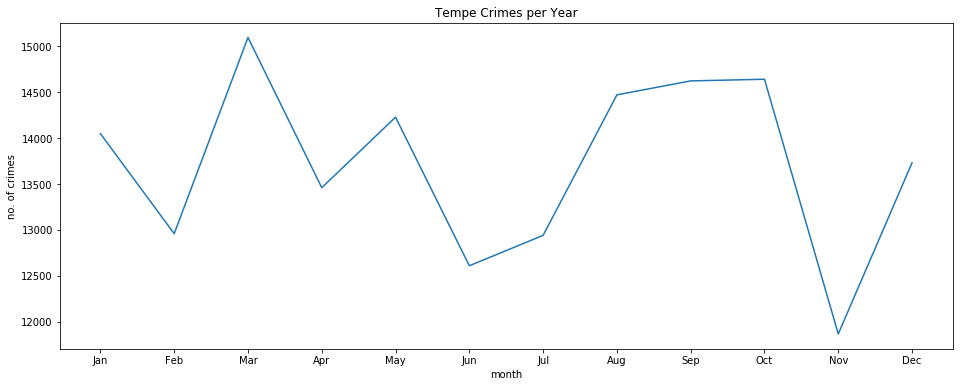

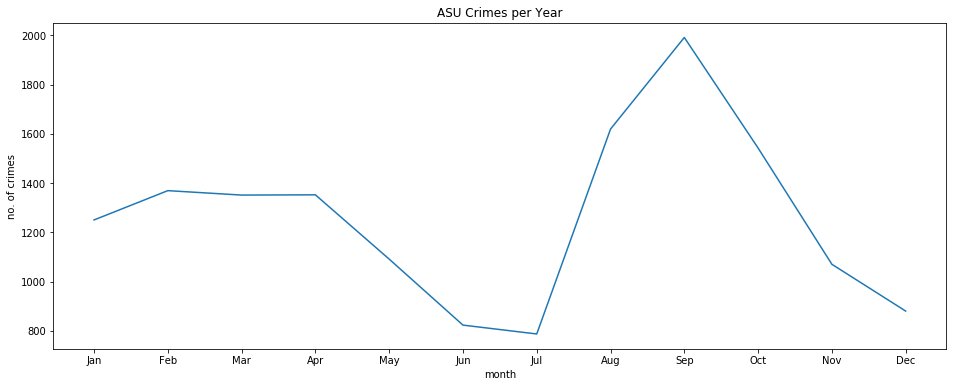

In [113]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Tempe Crime
tempe_monthly_crime_df = tempe_crime_df.groupby(['month'], as_index=False)[['id']].count()
# make plot big
plt.figure(figsize=(16, 6))
sns.lineplot(x="month", y="id", data=tempe_monthly_crime_df)
plt.xticks(np.arange(12), months)
plt.ylabel('no. of crimes')
plt.title('Tempe Crimes per Year')
plt.show()

# ASU Crime
asu_monthly_crime_df = asu_crime_df.groupby(['month'], as_index=False)[['id']].count()
# make plot big
plt.figure(figsize=(16, 6))
sns.lineplot(x="month", y="id", data=asu_monthly_crime_df)
plt.xticks(np.arange(12), months)
plt.ylabel('no. of crimes')
plt.title('ASU Crimes per Year')
plt.show()

Unsurprisingly, crime takes a dip in summer months when students aren't on campus. There's a significant upswing in crime in August, and in the ASU dataset August and September are the peak for numbers of crimes. This is probably due to students returning and students being caught drinking early in the semester when cops are on full patrol.

What is surprising is the drop of crime in November for the Tempe dataset. It bounces back in December, breaking the trend that breaks in classes = less students = less crime.

### 2.2 - Weekly Trends

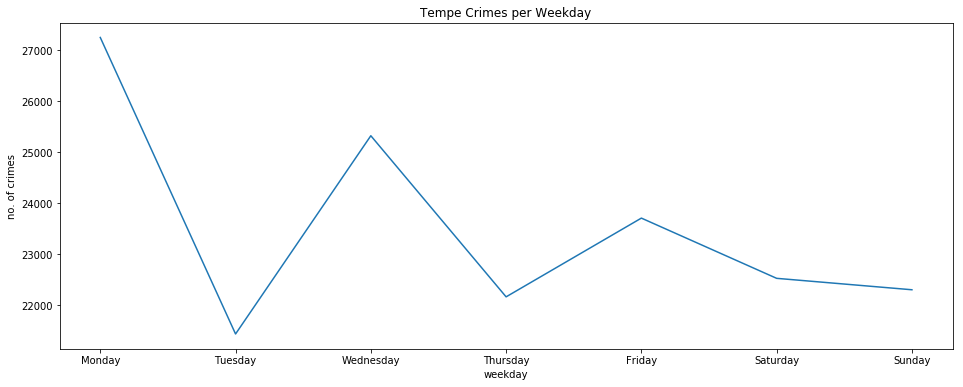

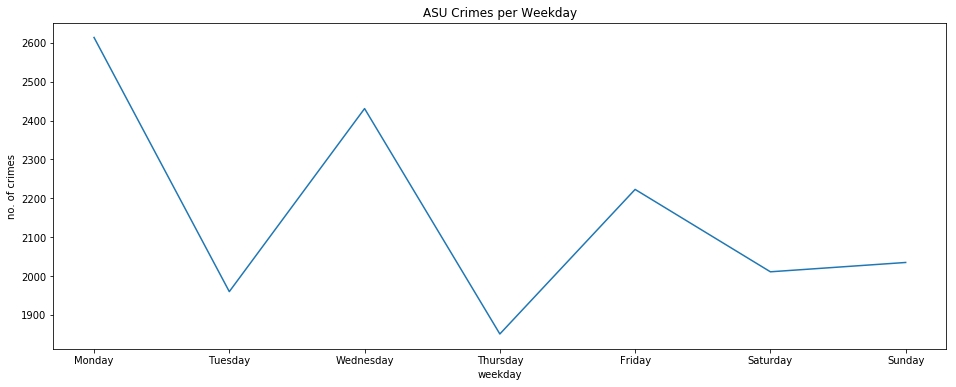

In [115]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Tempe Crime
tempe_weekday_crime_df = tempe_crime_df.groupby(['weekday'], as_index=False)[['id']].count()
# make plot big
plt.figure(figsize=(16, 6))
sns.lineplot(x="weekday", y="id", data=tempe_weekday_crime_df)
plt.xticks(np.arange(7), weekdays)
plt.ylabel('no. of crimes')
plt.title('Tempe Crimes per Weekday')
plt.show()

# ASU Crime
asu_weekday_crime_df = asu_crime_df.groupby(['weekday'], as_index=False)[['id']].count()
# make plot big
plt.figure(figsize=(16, 6))
sns.lineplot(x="weekday", y="id", data=asu_weekday_crime_df)
plt.xticks(np.arange(7), weekdays)
plt.ylabel('no. of crimes')
plt.title('ASU Crimes per Weekday')
plt.show()

### 2.3 - Types of Crime

Let's take a look at the types of crime and how often they occur. ASU's dataset includes a column for types of crime 

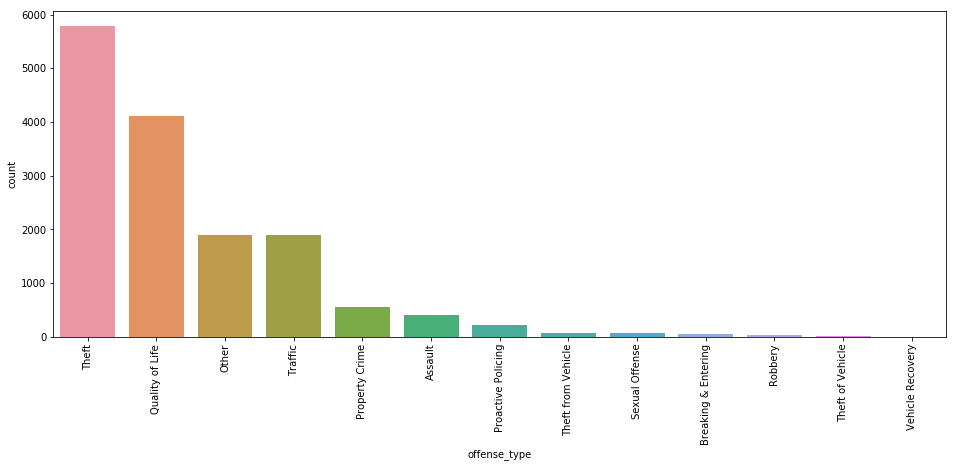

In [125]:
plt.figure(figsize=(16, 6))
sns.countplot(x='offense_type', data=asu_crime_df, order=asu_crime_df.offense_type.value_counts().index)
plt.xticks(rotation='vertical')
plt.show()